In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier # Import KNN
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [3]:
# Load data
train_df = pd.read_csv("titanic/train.csv")
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [19]:
def preprocess(df):
    df = df.copy()

    def normalize_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])

    def ticket_number(x):
        ticket_num = x.split(" ")[-1]
        if not ticket_num.isnumeric():
            ticket_num = float('nan')
        return ticket_num

    def ticket_item(x):
        items = x.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[0:-1])

    df["Name"] = df["Name"].apply(normalize_name)
    df["Ticket_number"] = df["Ticket"].apply(ticket_number)
    df["Ticket_item"] = df["Ticket"].apply(ticket_item)
    return df

preprocessed_train_df = preprocess(train_df)
#preprocessed_serving_df = preprocess(serving_df)

preprocessed_train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_number,Ticket_item
0,1,0,3,Braund Mr Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S,21171,A/5
1,2,1,1,Cumings Mrs John Bradley Florence Briggs Thayer,female,38.0,1,0,PC 17599,71.2833,C85,C,17599,PC
2,3,1,3,Heikkinen Miss Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3101282,STON/O2.
3,4,1,1,Futrelle Mrs Jacques Heath Lily May Peel,female,35.0,1,0,113803,53.1000,C123,S,113803,NONE
4,5,0,3,Allen Mr William Henry,male,35.0,0,0,373450,8.0500,NaN,S,373450,NONE


In [20]:
# Remove features we don't want to use
# PassengerId is self defined
# Ticket is split into two features
# Survived is the output
input_features = list(preprocessed_train_df.columns)
unwanted_features = ['Ticket', 'PassengerId', 'Survived']

for feature in unwanted_features:
    input_features.remove(feature)

print(f"Input features: {input_features}")

Input features: ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Ticket_number', 'Ticket_item']


In [21]:
# Split into X and y for input and output
X = preprocessed_train_df[input_features]
y = preprocessed_train_df['Survived']
print(X.head(5))
print(y.head(5))

   Pclass                                             Name     Sex   Age  \
0       3                            Braund Mr Owen Harris    male  22.0   
1       1  Cumings Mrs John Bradley Florence Briggs Thayer  female  38.0   
2       3                             Heikkinen Miss Laina  female  26.0   
3       1         Futrelle Mrs Jacques Heath Lily May Peel  female  35.0   
4       3                           Allen Mr William Henry    male  35.0   

   SibSp  Parch     Fare Cabin Embarked Ticket_number Ticket_item  
0      1      0   7.2500   NaN        S         21171         A/5  
1      1      0  71.2833   C85        C         17599          PC  
2      0      0   7.9250   NaN        S       3101282    STON/O2.  
3      1      0  53.1000  C123        S        113803        NONE  
4      0      0   8.0500   NaN        S        373450        NONE  
0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64


In [37]:
# Split into numerical and categorical features so we can infer missing values
numerical_features = ['Pclass', 'Age', 'Fare', 'Ticket_number', 'SibSp', 'Parch']
categorical_features = ['Sex', 'Embarked']

In [38]:
# Numerical pipeline: Impute missing values with median, then scale
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()) # Scaling is crucial for KNN
])

# Categorical pipeline: Impute missing values with most frequent, then one-hot encode
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# ColumnTransformer to apply different transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder='drop'
)


In [39]:
# --- 3. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [40]:
# --- 4. Create and Train K-Nearest Neighbors Model ---
# We'll create a full pipeline including preprocessing and the KNN model
# The number of neighbors (k) is a key hyperparameter. We can start with a common value like 5.
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5)) # Using KNN here
])

# Train the model
print("\n--- Training the K-Nearest Neighbors Model (with k=5) ---")
knn_pipeline.fit(X_train, y_train)
print("Model training complete.")



--- Training the K-Nearest Neighbors Model (with k=5) ---
Model training complete.


In [41]:
# --- 5. Make Predictions ---
y_pred_train = knn_pipeline.predict(X_train)
y_pred_test = knn_pipeline.predict(X_test)
y_pred_proba_test = knn_pipeline.predict_proba(X_test)[:, 1]


In [42]:
# --- 6. Evaluate Model (with k=5) ---
print("\n--- Model Evaluation (with k=5) ---")
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")



--- Model Evaluation (with k=5) ---
Training Accuracy: 0.8511
Test Accuracy: 0.7933



Confusion Matrix (Test Set):
[[98 12]
 [25 44]]


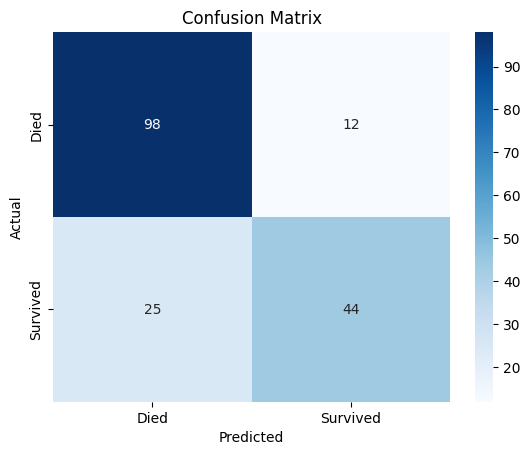

In [43]:
print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_pred_test)
print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Died', 'Survived'], yticklabels=['Died', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [44]:
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, target_names=['Died (0)', 'Survived (1)']))



Classification Report (Test Set):
              precision    recall  f1-score   support

    Died (0)       0.80      0.89      0.84       110
Survived (1)       0.79      0.64      0.70        69

    accuracy                           0.79       179
   macro avg       0.79      0.76      0.77       179
weighted avg       0.79      0.79      0.79       179



In [45]:
roc_auc = roc_auc_score(y_test, y_pred_proba_test)
print(f"\nROC AUC Score (Test Set): {roc_auc:.4f}")



ROC AUC Score (Test Set): 0.8480


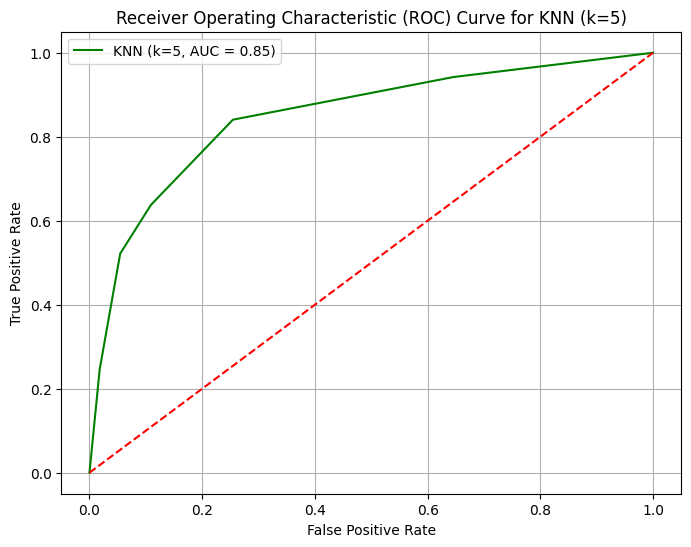

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', label=f'KNN (k=5, AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for KNN (k=5)')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
# --- 7. Hyperparameter Tuning for K (Number of Neighbors) ---
print("\n--- Hyperparameter Tuning for K ---")
# We can try a range of k values and see which one performs best on the test set
# (Ideally, use a separate validation set or cross-validation for this)

k_values = range(1, 31) # Test k from 1 to 30
test_accuracies = []
train_accuracies = [] # To observe potential overfitting
roc_aucs = []

for k in k_values:
    # Create a new pipeline for each k
    temp_knn_pipeline = Pipeline([
        ('preprocessor', preprocessor), # Use the same preprocessor
        ('classifier', KNeighborsClassifier(n_neighbors=k))
    ])
    temp_knn_pipeline.fit(X_train, y_train)
    
    # Store accuracies
    train_accuracies.append(temp_knn_pipeline.score(X_train, y_train))
    test_accuracies.append(temp_knn_pipeline.score(X_test, y_test))
    roc_aucs.append(roc_auc_score(y_test, temp_knn_pipeline.predict_proba(X_test)[:,1]))



--- Hyperparameter Tuning for K ---


In [54]:
print(roc_aucs[8])

0.8382081686429512


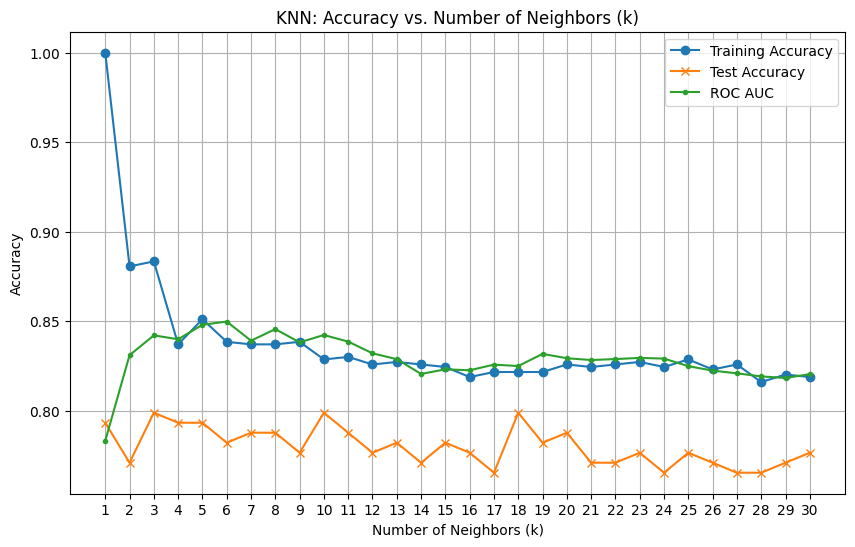

Best k found: 3 with a test accuracy of 0.7989


In [53]:

# Plotting the results of k tuning
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(k_values, test_accuracies, marker='x', label='Test Accuracy')
plt.plot(k_values, roc_aucs, marker='.', label='ROC AUC')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN: Accuracy vs. Number of Neighbors (k)')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

best_k_index = np.argmax(test_accuracies)
best_k = k_values[best_k_index]
best_accuracy = test_accuracies[best_k_index]
print(f"Best k found: {best_k} with a test accuracy of {best_accuracy:.4f}")


In [49]:

print("\n--- Re-training and Evaluating with Best K ---")
# You would typically use GridSearchCV for a more robust search and cross-validation
# Example with GridSearchCV:
param_grid = {'classifier__n_neighbors': range(1, 31)} # Note: 'classifier__' prefix for pipeline parameters

# Create a GridSearchCV object
# cv=5 means 5-fold cross-validation
grid_search_knn = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

print("Running GridSearchCV...")
grid_search_knn.fit(X_train, y_train)

print(f"Best parameters found by GridSearchCV: {grid_search_knn.best_params_}")
print(f"Best cross-validated accuracy: {grid_search_knn.best_score_:.4f}")

# Evaluate the best model from GridSearchCV on the test set
best_knn_model = grid_search_knn.best_estimator_
y_pred_test_best_knn = best_knn_model.predict(X_test)
y_pred_proba_test_best_knn = best_knn_model.predict_proba(X_test)[:, 1]

print("\n--- Evaluation of Best KNN Model from GridSearchCV (Test Set) ---")
best_test_accuracy = accuracy_score(y_test, y_pred_test_best_knn)
print(f"Test Accuracy (Best KNN): {best_test_accuracy:.4f}")
print("\nConfusion Matrix (Best KNN - Test Set):")
print(confusion_matrix(y_test, y_pred_test_best_knn))
print("\nClassification Report (Best KNN - Test Set):")
print(classification_report(y_test, y_pred_test_best_knn, target_names=['Died (0)', 'Survived (1)']))
roc_auc_best_knn = roc_auc_score(y_test, y_pred_proba_test_best_knn)
print(f"\nROC AUC Score (Best KNN - Test Set): {roc_auc_best_knn:.4f}")

# --- 8. Feature Importance (KNN doesn't have direct coefficients) ---
# KNN is a non-parametric model and doesn't have coefficients like linear models.
# Feature importance can be estimated using techniques like:
# 1. Permutation Importance: Measure the decrease in model score when a single feature's values are randomly shuffled.
# 2. By observing how model performance changes when features are added/removed (less systematic).
# This is more advanced and not typically covered in a basic KNN introduction.
print("\n--- Feature Importance ---")
print("KNN does not provide direct feature coefficients like linear models.")
print("Feature importance can be assessed using methods like Permutation Importance (requires further steps).")


--- Re-training and Evaluating with Best K ---
Running GridSearchCV...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found by GridSearchCV: {'classifier__n_neighbors': 9}
Best cross-validated accuracy: 0.8175

--- Evaluation of Best KNN Model from GridSearchCV (Test Set) ---
Test Accuracy (Best KNN): 0.7765

Confusion Matrix (Best KNN - Test Set):
[[96 14]
 [26 43]]

Classification Report (Best KNN - Test Set):
              precision    recall  f1-score   support

    Died (0)       0.79      0.87      0.83       110
Survived (1)       0.75      0.62      0.68        69

    accuracy                           0.78       179
   macro avg       0.77      0.75      0.76       179
weighted avg       0.77      0.78      0.77       179


ROC AUC Score (Best KNN - Test Set): 0.8382

--- Feature Importance ---
KNN does not provide direct feature coefficients like linear models.
Feature importance can be assessed using methods like Permutation Importance (requi